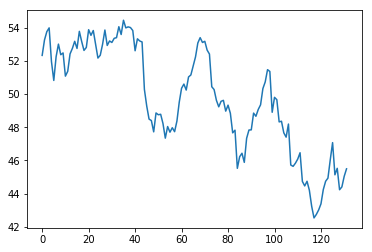

In [4]:
import pandas
import matplotlib.pyplot as plt
dataset = pandas.read_csv('WTI.csv', usecols=[1], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()


In [5]:
import numpy as np
SEQ_LEN = 10
def create_time_series():
  freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
  ampl = np.random.random() + 0.5  # 0.5 to 1.5
  x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl
  return x

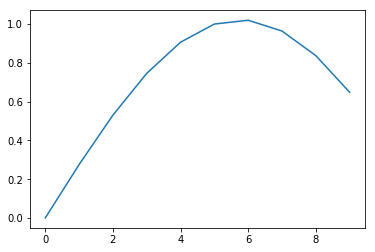

In [6]:
plt.plot(create_time_series())
plt.show()

In [25]:
import tensorflow as tf
print (tf.__version__)

1.2.1


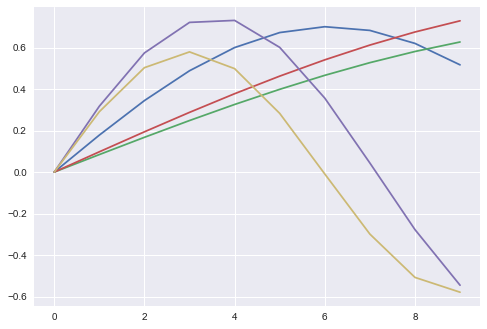

In [10]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

SEQ_LEN = 10
def create_time_series():
  freq = (np.random.random()*0.5) + 0.1  # 0.1 to 0.6
  ampl = np.random.random() + 0.5  # 0.5 to 1.5
  x = np.sin(np.arange(0,SEQ_LEN) * freq) * ampl
  return x

for i in range(0, 5):
  plt.plot( create_time_series() );  # 5 series

plt.show()

In [12]:
def to_csv(filename, N):
  with open(filename, 'w') as ofp:
    for lineno in range(0, N):
      seq = create_time_series()
      line = ",".join(map(str, seq))
      ofp.write(line + '\n')

to_csv('train.csv', 1000)  # 1000 sequences
to_csv('valid.csv',  50)

In [14]:
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

In [16]:
DEFAULTS = [[0.0] for x in range(0, SEQ_LEN)]
BATCH_SIZE = 20
TIMESERIES_COL = 'rawdata'
N_OUTPUTS = 2  # in each sequence, 1-8 are features, and 9-10 is label
N_INPUTS = SEQ_LEN - N_OUTPUTS


In [20]:

# read data and convert to needed format
def read_dataset(filename, mode=tf.contrib.learn.ModeKeys.TRAIN):  
  def _input_fn():
    num_epochs = 100 if mode == tf.contrib.learn.ModeKeys.TRAIN else 1
    
    # could be a path to one file or a file pattern.
    input_file_names = tf.train.match_filenames_once(filename)
    
    filename_queue = tf.train.string_input_producer(
        input_file_names, num_epochs=num_epochs, shuffle=True)
    reader = tf.TextLineReader()
    _, value = reader.read_up_to(filename_queue, num_records=BATCH_SIZE)

    value_column = tf.expand_dims(value, -1)
    print ('readcsv={}'.format(value_column))
    
    # all_data is a list of tensors
    all_data = tf.decode_csv(value_column, record_defaults=DEFAULTS)  
    inputs = all_data[:len(all_data)-N_OUTPUTS]  # first few values
    label = all_data[len(all_data)-N_OUTPUTS : ] # last few values
    
    # from list of tensors to tensor with one more dimension
    inputs = tf.concat(inputs, axis=1)
    label = tf.concat(label, axis=1)
    print ('inputs={}'.format(inputs))
    
    return {TIMESERIES_COL: inputs}, label   # dict of features, label
  return _input_fn

In [21]:
LSTM_SIZE = 3  # number of hidden layers in each of the LSTM cells

# create the inference model
def simple_rnn(features, targets, mode):
  # 0. Reformat input shape to become a sequence
  x = tf.split(features[TIMESERIES_COL], N_INPUTS, 1)
  #print 'x={}'.format(x)
    
  # 1. configure the RNN
  lstm_cell = rnn.BasicLSTMCell(LSTM_SIZE, forget_bias=1.0)
  outputs, _ = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

  # slice to keep only the last cell of the RNN
  outputs = outputs[-1]
  #print 'last outputs={}'.format(outputs)
  
  # output is result of linear activation of last layer of RNN
  weight = tf.Variable(tf.random_normal([LSTM_SIZE, N_OUTPUTS]))
  bias = tf.Variable(tf.random_normal([N_OUTPUTS]))
  predictions = tf.matmul(outputs, weight) + bias
    
  # 2. loss function, training/eval ops
  if mode == tf.contrib.learn.ModeKeys.TRAIN or mode == tf.contrib.learn.ModeKeys.EVAL:
     loss = tf.losses.mean_squared_error(targets, predictions)
     train_op = tf.contrib.layers.optimize_loss(
         loss=loss,
         global_step=tf.contrib.framework.get_global_step(),
         learning_rate=0.01,
         optimizer="SGD")
     eval_metric_ops = {
      "rmse": tf.metrics.root_mean_squared_error(targets, predictions)
     }
  else:
     loss = None
     train_op = None
     eval_metric_ops = None
  
  # 3. Create predictions
  predictions_dict = {"predicted": predictions}
  
  # 4. return ModelFnOps
  return tflearn.ModelFnOps(
      mode=mode,
      predictions=predictions_dict,
      loss=loss,
      train_op=train_op,
      eval_metric_ops=eval_metric_ops)

In [31]:
def get_train():
  return read_dataset('train.csv', mode=tf.contrib.learn.ModeKeys.TRAIN)

def get_valid():
  return read_dataset('valid.csv', mode=tf.contrib.learn.ModeKeys.EVAL)

def serving_input_fn():
    feature_placeholders = {
        TIMESERIES_COL: tf.placeholder(tf.float32, [None, N_INPUTS])
    }
  
    features = {
      key: tf.expand_dims(tensor, -1)
      for key, tensor in feature_placeholders.items()
    }
    features[TIMESERIES_COL] = tf.squeeze(features[TIMESERIES_COL], axis=[2])
    
    print ('serving: features={}'.format(features[TIMESERIES_COL]))
    
    return tflearn.utils.input_fn_utils.InputFnOps(
      features,
      None,
      feature_placeholders
    )

from tensorflow.contrib.learn.python.learn.utils import saved_model_export_utils
def experiment_fn(output_dir):
    # run experiment
    return tflearn.Experiment(
        tflearn.Estimator(model_fn=simple_rnn, model_dir=output_dir),
        train_input_fn=get_train(),
        eval_input_fn=get_valid(),
        eval_metrics={
            'rmse': tflearn.MetricSpec(
                metric_fn=metrics.streaming_root_mean_squared_error
            )
        },
        export_strategies=[saved_model_export_utils.make_export_strategy(
            serving_input_fn,
            default_output_alternative_key=None,
            exports_to_keep=1
        )]
    )

shutil.rmtree('outputdir', ignore_errors=True) # start fresh each time
learn_runner.run(experiment_fn, 'outputdir')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_ps_replicas': 0, '_tf_random_seed': None, '_task_type': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000001A7AFBE0>, '_model_dir': 'outputdir', '_num_worker_replicas': 0, '_task_id': 0, '_master': '', '_environment': 'local', '_save_summary_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_save_checkpoints_steps': None, '_is_chief': True, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_evaluation_master': '', '_keep_checkpoint_max': 5, '_session_config': None, '_save_checkpoints_secs': 600}
Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
readcsv=Tensor("ExpandDims:0", shape=(?, 1), dtype=string)
inputs=Tensor("concat:0", shape=(?, 8), dtype=float32)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into outputdir\model.ckpt.
INFO:tensorflow:step = 1, loss = 0.760269


TypeError: Can't mix strings and bytes in path components

In [26]:

import tensorflow as tf
import numpy as np

def breakup(sess, x, lookback_len):
  N = sess.run(tf.size(x))
  windows = [tf.slice(x, [b], [lookback_len]) for b in range(0, N-lookback_len)]
  windows = tf.stack(windows)
  return windows

x = tf.constant(np.arange(1,11, dtype=np.float32))
with tf.Session() as sess:
    print ('input=', x.eval())
    seqx = breakup(sess, x, 5)
    print ('output=', seqx.eval())

input= [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.]
output= [[ 1.  2.  3.  4.  5.]
 [ 2.  3.  4.  5.  6.]
 [ 3.  4.  5.  6.  7.]
 [ 4.  5.  6.  7.  8.]
 [ 5.  6.  7.  8.  9.]]
